**Author**: Fedor Sviridov

This document presents the results of an artificial intelligence project.

**Abstract**.
To attempt to solve a clustering problem for a large set of gamma-ray burst light curves: to apply a wavelet transform to them, extract features from the resulting scalograms using a pre-trained convolutional neural network, and finally apply clustering algorithms for high-dimensional data.

**Data Preparation**.  
I downloaded gamma-ray burst data recorded by the Fermi/GBM telescope from January 1, 2020 to the present. During this period, approximately 1060 bursts were detected. From the TTE data, light curves were constructed with a time resolution of 0.128 seconds in the energy range of 50–300 keV. The time interval for all light curves was chosen from −100 s to 400 s relative to the trigger time. Light curves that did not contain data covering this time interval were discarded. _Min–max_ scaling was applied to the light curves.

**Wavelet Transform**.  
For the wavelet analysis, I used the PyWavelets module. The mother wavelet was chosen as ‘cmor1.5-1.0’, with a bandwidth of 1.5 and a central frequency of 1.0. All normalized light curves were transformed using the same set of scales, corresponding to a frequency range from 10⁻⁴ Hz to 9.5 Hz. The result of the transform is a matrix of wavelet power spectrum coefficients (|w|²). These matrices were also normalized using _min–max_ scaling.

**Convolutional Neural Network**.  
To analyze the resulting scalogram images, CLIP was used—a pre-trained CNN whose purpose is to associate any image with a text description of that image (https://github.com/openai/CLIP.git).  
The input image must be three-channel with a resolution of 224 × 224; therefore, the scalogram matrices were resized to this resolution and replicated across three channels.  
As a result, features were extracted from approximately 1000 normalized scalograms, each feature vector having a dimensionality of 512.

**Dimensionality Reduction**.  
I attempted to include additional light-curve parameters such as duration, spectral characteristics, luminosity, and redshift, but this did not provide significant additional information and did not strongly affect the final clustering. Therefore, I restricted the analysis to parameters obtained solely from the scalogram images.

To reduce the dimensionality of the resulting data, I applied principal component analysis (PCA), retaining 30 components, which corresponds to approximately 95% of the total variance.

**Clustering**.  
For clustering, I used DBSCAN, with the parameter *eps* determined by constructing the k-nearest-neighbor distance plot. To visualize the DBSCAN results, I used the t-SNE algorithm; this method was also employed as an alternative approach for identifying clusters. The obtained results and conclusions are presented below.


In [11]:
# the main module
%matplotlib inline
import numpy as np
import pywt
import h5py
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
#import clip
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


def wavelet(signal, time, scales, wt="cmor1.5-1.0"):
    """
    Method to perform wavelet transformation (CWT)
    Parameters:
        signal (array) - signal values
        time (array) - array of time points (used to calculate sampling period)
        scales (array) - array of wavelet scales
        wt (str) - name of the mother wavelet
    Returns:
        (array) 2D array of wavelet power spectrum coefficients (|w|^2)
    """
    # logarithmic scale for scales, as suggested by Torrence & Compo:
    sampling_period = np.diff(time).mean()
    # frequency = scales**-1/sampling_period
    cwt_coeff, freqs = pywt.cwt(signal, scales, wt, sampling_period=sampling_period)

    # take the squeared absolute value of complex result and remove the bounds
    return (np.abs(cwt_coeff[:-1, :-1])**2, freqs)

def get_features(cwt_coeff):
    """
    To get features from wavelet images using CLIP
    https://github.com/openai/CLIP.git
    Parameters:
        cwt_coeff (array) - 2D array of any size (M, N)
    Returns:
        (1D array) 512 feauters of the image
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    # min-max normalization
    mn = np.min(cwt_coeff)
    mx = np.max(cwt_coeff)
    cwt_coeff = (cwt_coeff - mn)/(mx - mn)

    #convert to torch.tensor
    cwt_coeff_tensor = torch.from_numpy(cwt_coeff).unsqueeze(0).unsqueeze(0) #shape: [1, 1, H, W]
    # Resize [1, 1, H, W] -> [1,1,224,224]
    cwt_coeff_tensor = F.interpolate(cwt_coeff_tensor, size=(224, 224), mode='bilinear', align_corners=False)
    # Repeat the channel 3 times: [1,1,224,224] -> [1,3,224,224]
    cwt_coeff_tensor = cwt_coeff_tensor.repeat(1, 3, 1, 1).to(device)

    with torch.no_grad():
        image_features = model.encode_image(cwt_coeff_tensor)
    return image_features

def pca(features, n_components=50):
    """
    PCA algorithm
    Parameters:
        features (2D array) - sample of image feaures
        n_components (int) - final dimension
    Returns:
        print value of saved information
        (array) reduced features
    """
    pca = PCA(n_components=n_components)
    features_reduced = pca.fit_transform(features)
    total_variance_retained = np.sum(pca.explained_variance_ratio_)
    print(f'total_variance_retained = {total_variance_retained}')

    return features_reduced

def dbscan(red_features, eps=3, min_samples = 5):
    """
    The DBSCAN algorithm for custering
    Parameters:
        red_features (array) - input data
        eps (float) - maximum distance between two samples
                        for one to be considered as in the neighborhood of the other
        min_samples (int) - number of samples (or total weight) in a neighborhood
                            for a point to be considered as a core point
    Returns:
        (array) labels of the points
    """
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(red_features)
    return labels

def t_SNE(features, dimension=2, perplexity=20, learning_rate=200):
    """
    The method to visualize high-dimensional data
    Parameters:
        features (array) - input data
        dimension (int) - dimension of the embedded space
        perplexity (float) - is related to the number of nearest neighbors.
                            Consider selecting a value between 5 and 50
        learning_rate (float) - for t-SNE is usually in the range [10.0, 1000.0]
    """
    tsne = TSNE(
    n_components = dimension,
    perplexity=perplexity,
    learning_rate=learning_rate,
    n_iter=1000,
    random_state=42)

    return tsne.fit_transform(features)

In [12]:
with h5py.File('./features.h5', 'r') as file:
    names = np.array(list(file.keys()))
    problem_names = np.array(file.attrs['error_name'])

#remove GRB names having problems
names = names[~np.isin(names, problem_names)]
# get features for certain names
with h5py.File('./features.h5', 'r') as file:
    features = [file[f'{name}/features'][:] for name in names]


In [13]:
# Principal Component Analysis (PCA)
red_features = pca(features, n_components=30)
del features

total_variance_retained = 0.9518319667794948


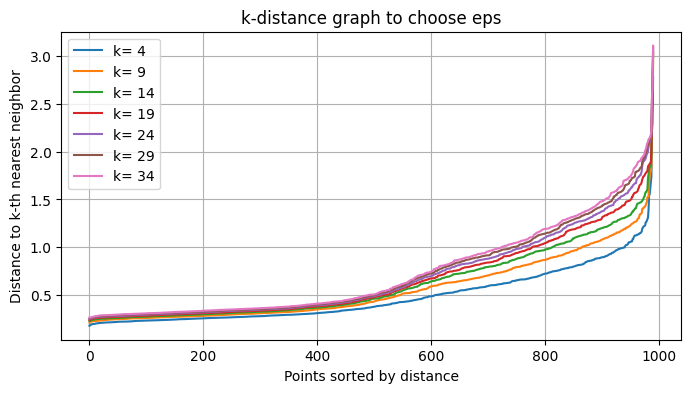

In [14]:
"""
Now we plot the k-distance graph to determine the optimal value 
for the eps parameter in the DBSCAN algorithm.
"""
def k_dist(features, min_samples):
    k = min_samples - 1

    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(red_features)
    distances, indices = neighbors_fit.kneighbors(red_features)

    k_distances = distances[:, k-1]
    k_distances = np.sort(k_distances)

    return k_distances

plt.figure(figsize=(8, 4))
for min_samples in range(5, 40, 5):
    k_distances = k_dist(red_features, min_samples)
    plt.plot(k_distances, label=f'k= {min_samples - 1}')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to k-th nearest neighbor')
plt.title('k-distance graph to choose eps')
plt.grid(True)
plt.legend()
#plt.yscale('log')
plt.show()

/home/student/fyodor/venv/clip_cnn/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


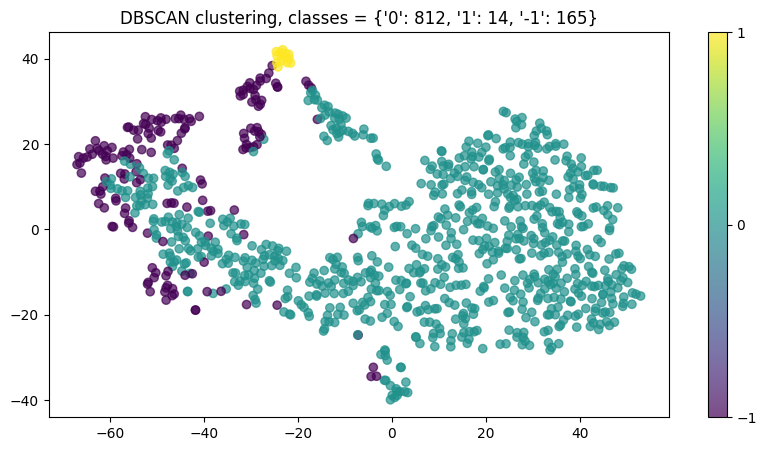

In [15]:
# DBSCAN clastering
eps = 0.8
min_samples = 10

labels = dbscan(red_features ,eps=eps, min_samples=min_samples)

classes  = {str(lb): names[labels == lb] for lb in set(labels)}
n = {lb: len(classes[lb]) for lb in classes.keys()}

# t-SNE visualization
perplexity = 20
features_2d = t_SNE(red_features, perplexity=perplexity, learning_rate=200)

unique_labels = np.unique(labels)
plt.figure(figsize=(10,5))
sc = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels, alpha=0.7)
plt.title(f'DBSCAN clustering, classes = {n}')
cbar = plt.colorbar(sc, ticks=unique_labels)
plt.show()

I was unable to obtain any interesting classes/clusters based on the selected data. The DBSCAN algorithm identifies only a small number of bursts (outliers) – cluster label 1 (the yellow class). This class contains just 15 bursts, and almost all of them have short durations.

Duration of GRBs from 1-st class: [ 0.144  0.32   5.312  1.136  0.112  4.672  0.176  0.576  1.024 37.121
  0.352  0.152  3.968  0.768]
Mean duration of 1-st class: 3.9880714285714283
Mean duration is: 39.78962058526741


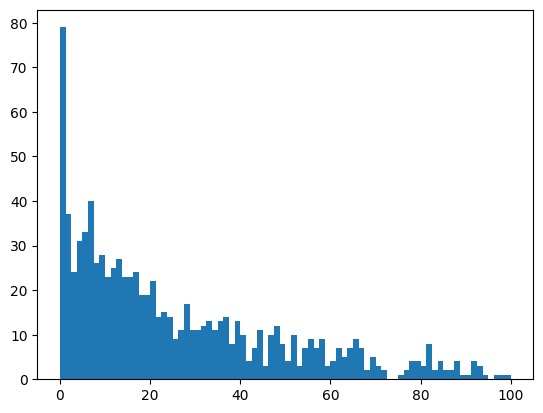

In [16]:
with h5py.File('./duration.h5', 'r') as file:
    duration = np.array(file['duration'])

mask = np.isin(names, classes['1'])
unusual_grbs = names[mask]
print(f'Duration of GRBs from 1-st class: {duration[np.isin(names, unusual_grbs)]}')
print(f'Mean duration of 1-st class: {duration[np.isin(names, unusual_grbs)].mean()}')
print(f'Mean duration is: {duration.mean()}')
plt.hist(duration, bins = 80, range=(0, 100));

Therefore, I was only able to identify a small number of short gamma-ray bursts. The following figure shows the distribution of burst durations.

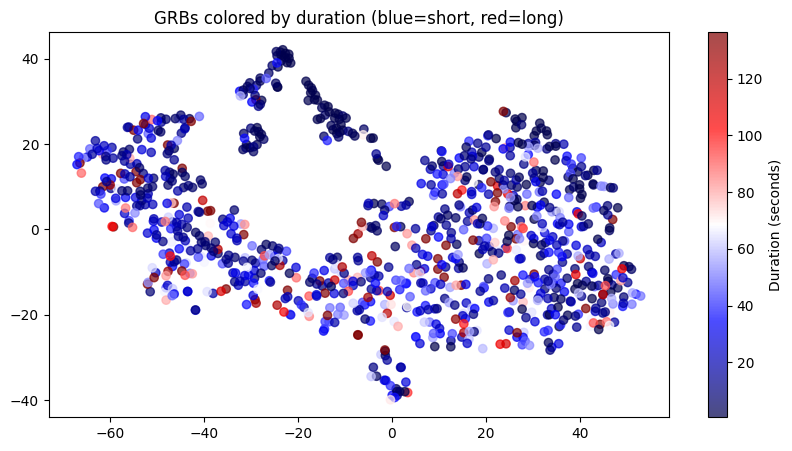

In [17]:
low, high = np.percentile(duration, [5, 95])
duration = np.clip(duration, low, high)

plt.figure(figsize=(10, 5))
sc = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                c=duration, cmap='seismic', alpha=0.7)
plt.colorbar(label='Duration (seconds)')
plt.title('GRBs colored by duration (blue=short, red=long)')
plt.show()

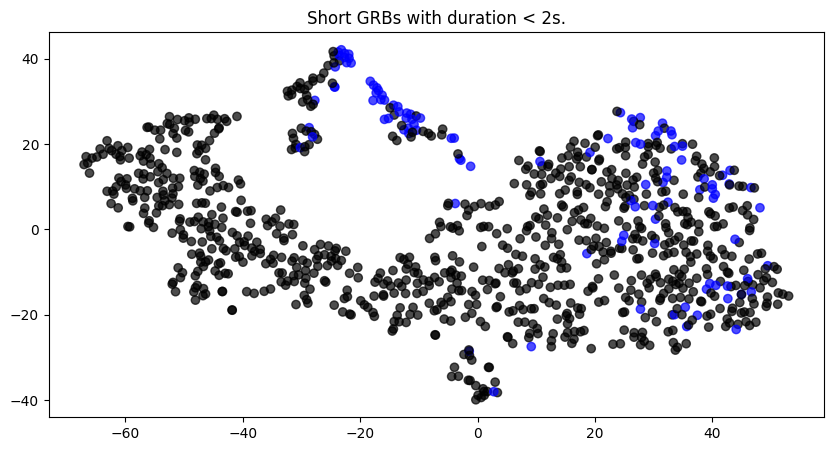

In [18]:
# Following figure displays bursts with durations shorter than 2 seconds
with h5py.File('./features.h5', 'r') as file:
    short_grbs = file.attrs['short_grbs']

y = np.isin(names, short_grbs)
c = ['blue' if g else 'black' for g in y]

plt.figure(figsize=(10,5))
sc = plt.scatter(features_2d[:,0], features_2d[:,1], c=c, alpha=0.7)
plt.title(f'Short GRBs with duration < 2s.')
plt.show()

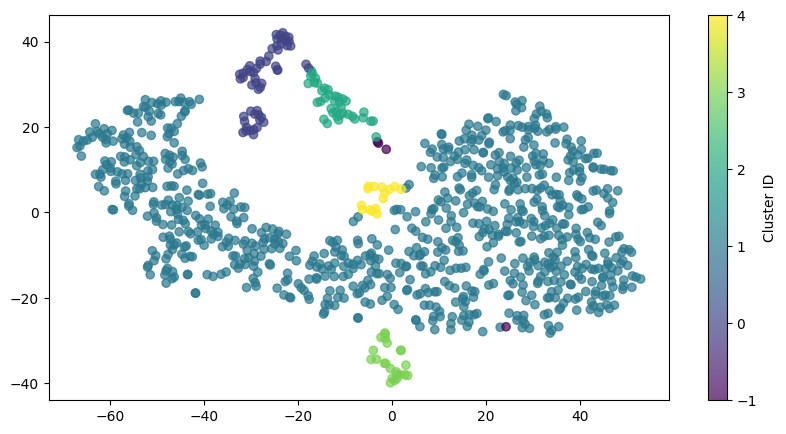

In [19]:
#Clustering of the 2D representation obtained from t-SNE using DBSCAN
eps = 6.5
min_samples = 20

labels = dbscan(features_2d ,eps=eps, min_samples=min_samples)
unique_labels = np.unique(labels)

plt.figure(figsize=(10,5))
sc = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels, cmap='viridis', alpha=0.7)
cbar = plt.colorbar(sc, ticks=unique_labels)
cbar.set_label('Cluster ID')
plt.show()

**Conclusions**.  
The performed clustering analysis of gamma-ray bursts did not reveal well-defined structures, except for a weak separation into short and long bursts. This may be attributed to several factors:

- **Coarse data selection** — the bursts selected in this study exhibit certain limitations, and a more careful data selection procedure should be applied.
- **Initial feature set** — the extracted features may be insufficiently informative for identifying meaningful clusters. In future studies, it would be worthwhile to consider augmenting the scalogram-based features with additional parameters such as duration, spectral characteristics, luminosity, and redshift.
- **Wavelet choice** — since the results strongly depend on the choice of the mother wavelet, a comparative analysis of different wavelet families (Daubechies, Haar, Morlet, etc.) should be conducted.
